In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from dataclasses import dataclass
from typing import Dict, Tuple, Iterable
from Utils.Plot_Helper import plot_1d_data

In [2]:
plt.ioff()

def select_data(experiment):
    if experiment == 'ungm':
        exp_table = 'UNGM_EXP'
        con = sqlite3.connect("../Experiments/ungm_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bot':
        exp_table = 'BOT_EXP'
        con = sqlite3.connect("../Experiments/bot_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bott':
        exp_table = 'BOTT_EXP'
        con = sqlite3.connect("../log/bott_final.db", detect_types=sqlite3.PARSE_DECLTYPES)

    cursor = con.cursor()
    return exp_table, cursor

    
@dataclass
class PlotConfig:
    figsize: Tuple = (12, 5)
    xlabel_fontsize: int = 16
    ylabel_fontsize: int = 16
    title_fontsize: int = 16
    legend_fontsize: int = 12
    xticks: Iterable = None
    xtick_labels: Iterable = None
    xtick_labelsize: int = 16
    yticks: Iterable = None
    ytick_labels: Iterable = None
    ytick_labelsize: int = 16
    cbar_ticks: Iterable = None
    cbar_tick_labels: Iterable = None
    vmin_rmse: float = None
    vmax_rmse: float = None
    vmin_nll: float = None
    vmax_nll: float = None
    xmin: float = None
    xmax: float = None


@dataclass
class ExpConfig:
    Seeds: Iterable
    exp_tablename : str
    cursor: sqlite3.Cursor


def _split_variables(control_vars):
    """ Split variables (Power, Damping, Iter) into a control set (fixed during plot) and a dependent set
    """
    control_varnames = list(control_vars.keys())
    control_vardata = []
    for key in control_varnames:
        control_vardata.append(control_vars[key])
    
    vars = ['Power', 'Damping', 'Iter']
    for key in control_varnames:
        assert key in vars, 'Control variable must be one of (Power, Damping, Iter)'

    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={}"
    for var in control_varnames:
        query_str = query_str + f" AND {var}"
        if var == 'Transform':
            query_str = query_str + "='{}'"
        else:
             query_str = query_str + "={}"
        vars.remove(var)

    dependent_varnames = vars

    return control_varnames, dependent_varnames, control_vardata, query_str
    

def plot_experiment(
        control_vars: Dict, metric: str,
        plot_config: PlotConfig, exp_config: ExpConfig, ax=None,
        trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'],
        power_display_name='Power', damping_display_name='Damping', iter_display_name='Iteration',
        title=True, xlabel=True, ylabel=True, legend=True, figsize=None
        ):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rsme, nll)'
    assert len(trans_types) == len(colors), 'Number of transformation types and colors must match'

    # Get data and variable names (e.g. Power and Damping)
    control_varnames, dependent_varname, control_vardata, query_str = _split_variables(control_vars)
    assert len(control_varnames) == 2, 'Must specify two control variables'
    data1, data2 = control_vardata[0][0], control_vardata[1][0]
    key1, key2 = control_varnames
    key3 = dependent_varname[0]
    labels = {'Power': power_display_name, 'Damping': damping_display_name, 'Iter': iter_display_name}

    Seeds, exp_table, cursor = exp_config.Seeds, exp_config.exp_tablename, exp_config.cursor
    if Seeds is None:
        Seeds = cursor.fetchall()
        Seeds = [seed[0] for seed in Seeds]

    # Create figure
    if ax is None:
        figsize_ = figsize if figsize is not None else plot_config.figsize # Override figsize when specified explicitly
        fig = plt.figure(figsize=figsize_)
        ax = plt.gca()
    ax.set_facecolor('#EBEBEB')
    ax.grid(True, color='w', linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    plt.rcParams['xtick.labelsize'] = plot_config.xtick_labelsize
    plt.rcParams['ytick.labelsize'] = plot_config.ytick_labelsize

    for c, trans_id in zip(colors, trans_types):
        data = []
        for SEED in Seeds:
            row = cursor.execute(query_str.format(metric, exp_table, trans_id, int(SEED), data1, data2)).fetchall()
            data.append(np.array(row).squeeze()[:50])
        data = np.array(data)

        ax = plot_1d_data(data, label=trans_id, c=c, ax=ax, linewidth=2.5)
    
    # Set title, labels and legend
    if title:
        ax.set_title(f"{labels[key1]}: {data1}, {labels[key2]}: {data2}", fontsize=plot_config.title_fontsize)
    if ylabel:
        if metric == 'rmse':
            ax.set_ylabel("RMSE", fontsize=plot_config.ylabel_fontsize)
        elif metric == 'nll':
            ax.set_ylabel("NLL", fontsize=plot_config.ylabel_fontsize)
    if xlabel:
        ax.set_xlabel(f"{labels[key3]}", fontsize=plot_config.xlabel_fontsize)
    if legend:
        ax.legend(fontsize=plot_config.legend_fontsize, loc='upper right', ncol=3)

    # Format axes (ticks, ticklabels, limits)
    xticks, yticks = plot_config.xticks, plot_config.yticks
    xticklabels, yticklabels = plot_config.xtick_labels, plot_config.ytick_labels
    if xticks is not None: ax.set_xticks(xticks)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)
    if yticks is not None: ax.set_yticks(yticks)
    if yticklabels is not None: ax.set_yticklabels(yticklabels)

    if metric == 'rmse':
        vmin, vmax = plot_config.vmin_rmse, plot_config.vmax_rmse
    elif metric == 'nll':
        vmin, vmax = plot_config.vmin_nll, plot_config.vmax_nll

    ax.set_ylim(vmin, vmax)
    if plot_config.xmin is not None and plot_config.xmax is not None:
        xmin, xmax = plot_config.xmin, plot_config.xmax
        ax.set_xlim(xmin, xmax)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(-3,3))

    # Remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()

    return ax


def plot_multiple_experiments(
        control_vars: Dict, plot_config: PlotConfig, exp_config: ExpConfig,
        trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'],
        power_display_name='Power', damping_display_name='Damping', iter_display_name='Iteration',
        ):
    assert len(trans_types) == len(colors), 'Number of transformation types and colors must match'
    control_varnames, dependent_varname, control_vardata, query_str = _split_variables(control_vars)
    assert len(control_varnames) == 2, 'Must specify two control variables'
    data1, data2 = control_vardata
    key1, key2 = control_varnames

    # Plot results
    ncol = len(data1)
    fig, axs = plt.subplots(2, ncol, figsize=plot_config.figsize)
    for i, params in enumerate(zip(data1, data2)):
        param1, param2 = params
        data = {key1: [param1], key2: [param2]}
        kwargs = {'trans_types': trans_types,
                  'colors': colors,
                  'power_display_name': power_display_name,
                  'damping_display_name': damping_display_name,
                  'iter_display_name': iter_display_name,
                  'title': True, 'xlabel': False,
                  'ylabel': False, 'legend': True}
        if i == 0:
            kwargs['ylabel'] = True
        
        rmse_ax = axs[0] if ncol==1 else axs[0,i]
        nll_ax = axs[1] if ncol==1 else axs[1,i]
        plot_experiment(data, 'rmse', plot_config, exp_config, ax=rmse_ax, **kwargs)
        kwargs['xlabel'] = True
        kwargs['title'] = False
        plot_experiment(data, 'nll', plot_config, exp_config, ax=nll_ax, **kwargs)

    plt.tight_layout()

    return fig, axs


def first_iteration_mean(exp_config, trans_type='UT'):
    rmse_list = []
    nll_list = []
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Damping=1.0 AND Power=1.0 AND Iter=1"
    for seed in exp_config.Seeds:
        row = cursor.execute(query_str.format('RMSE', exp_config.exp_tablename, trans_type, seed)).fetchall()
        rmse_list.append(row[0][0])
        row = cursor.execute(query_str.format('NLL', exp_config.exp_tablename, trans_type, seed)).fetchall()
        nll_list.append(row[0][0])
    average_rmse = np.array(rmse_list).mean()
    average_nll = np.array(nll_list).mean()
    return average_rmse, average_nll


def plot_first_iteration_results(axs, exp_config, trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'], metric='rmse', linewidth=2.5):
    for i, trans_type in enumerate(trans_types):
        average_rmse, average_nll = first_iteration_mean(exp_config, trans_type)
        try: # Multiple axis case
            for j in range(3):
                axs[0, j].axhline(average_rmse, c=colors[i], ls='--', linewidth=linewidth)
                axs[1, j].axhline(average_nll, c=colors[i], ls='--', linewidth=linewidth)
        except TypeError: # Single axis case
            assert metric in ['rmse', 'nll'], 'Specified metric must be either rmse or nll'
            if metric == 'rmse':
                axs.axhline(average_rmse, c=colors[i], ls='--', linewidth=linewidth, dashes=(5, 5))
            if metric == 'nll':
                axs.axhline(average_nll, c=colors[i], ls='--', linewidth=linewidth, dashes=(5, 5))

    return axs

## 1. Plots for the UNGM Experiment

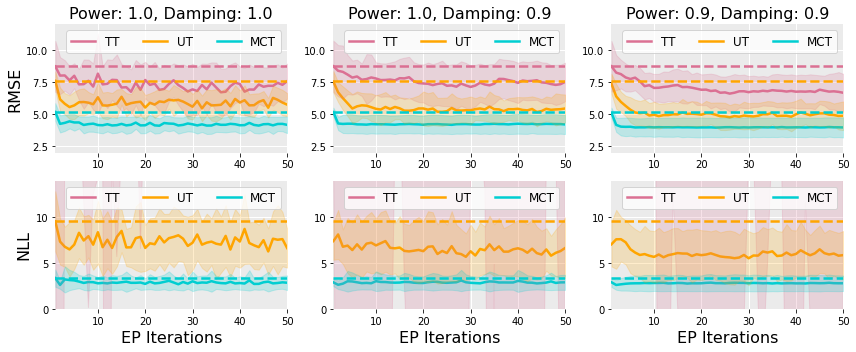

In [3]:
# Plot all experiments
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
Seeds = np.arange(101, 1101, 100)
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=2,
                         vmax_rmse=12,
                         vmin_nll=0,
                         vmax_nll=14,
                         xmin=1,
                         xmax=50)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)
power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors = ['palevioletred', 'orange', 'darkturquoise']
# ['palevioletred', 'orange', 'darkturquoise']
# ['salmon', 'orange', 'grey']
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, iter_display_name='EP Iterations', colors=colors) #, trans_types=['UT', 'MCT'], colors=[colors[1], colors[2]])
axs = plot_first_iteration_results(axs, exp_config, colors=colors) #, trans_types=['UT', 'MCT'], colors=[colors[1], colors[2]])

plt.show()

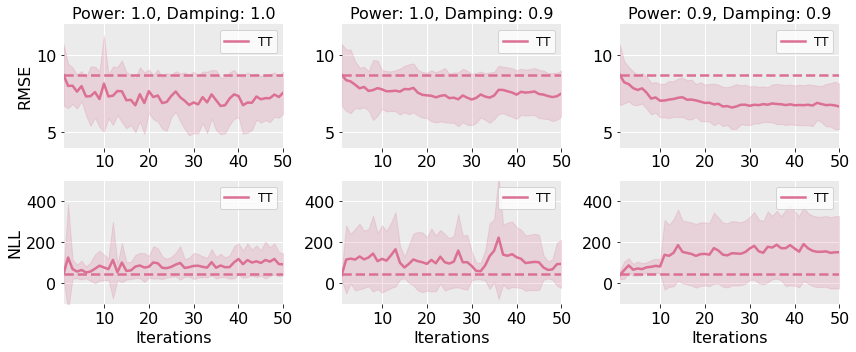

In [4]:
# Plot for Taylor transform only
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=4, vmax_rmse=12,
                         vmin_nll=-100, vmax_nll=500,
                         xmin=1, xmax=50)
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, trans_types=['TT'], colors=[colors[0]], iter_display_name='Iterations')
axs = plot_first_iteration_results(axs, exp_config, trans_types=['TT'], colors=[colors[0]])

plt.show()

In [5]:
# Save figures to use for paper
plot_config = PlotConfig(figsize=(8,4),
                         xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=2, vmax_rmse=12,
                         vmin_nll=0, vmax_nll=14,
                         xmin=1, xmax=50,
                         xlabel_fontsize=26, ylabel_fontsize=26,
                         title_fontsize=26, legend_fontsize=22,
                         xtick_labelsize=22, ytick_labelsize=22)
Seeds = np.arange(101, 1101, 100)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)

def _permute(control_vars):
    for key, value in control_vars.items():
        new_values = []
        N = len(value)
        for i in range(1, N+1):
            new_values.append(value[i%N])
        control_vars[key] = new_values


power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors=['palevioletred', 'orange', 'darkturquoise']
colors2=['palevioletred', 'darkorange', 'darkturquoise']

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, colors=colors2, metric='rmse', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, trans_types=['UT', 'MCT'], colors=colors[1:], iter_display_name='EP Iterations', title=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['UT', 'MCT'], colors=colors2[1:], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False, ylabel=False)
ax = plot_first_iteration_results(ax, exp_config, colors=colors2, metric='rmse', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, trans_types=['UT', 'MCT'], colors=colors[1:], iter_display_name='EP Iterations', ylabel=False, title=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['UT', 'MCT'], colors=colors2[1:], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False, ylabel=False)
ax = plot_first_iteration_results(ax, exp_config, colors=colors2, metric='rmse', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, trans_types=['UT', 'MCT'], colors=colors[1:], iter_display_name='EP Iterations', ylabel=False, title=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['UT', 'MCT'], colors=colors2[1:], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

plt.close('all') # plt.show()

In [6]:
# Save NLL plots for TT only
power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}
plot_config = PlotConfig(figsize=(8,3.4),
                         xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=4, vmax_rmse=12,
                         vmin_nll=-100, vmax_nll=500,
                         xmin=1, xmax=50,
                         xlabel_fontsize=26, ylabel_fontsize=26,
                         title_fontsize=26, legend_fontsize=22,
                         xtick_labelsize=22, ytick_labelsize=22)

ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, iter_display_name='EP Iterations', trans_types=['TT'], colors=[colors[0]], title=False, xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['TT'], colors=[colors[0]], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL_TT_only.pdf")
_permute(control_vars)
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, iter_display_name='EP Iterations', trans_types=['TT'], colors=[colors[0]], ylabel=False, title=False, xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['TT'], colors=[colors[0]], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL_TT_only.pdf")
_permute(control_vars)
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, iter_display_name='EP Iterations', trans_types=['TT'], colors=[colors[0]], ylabel=False, title=False, xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['TT'], colors=[colors[0]], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL_TT_only.pdf")

plt.close('all') # plt.show()

### Sweep across power

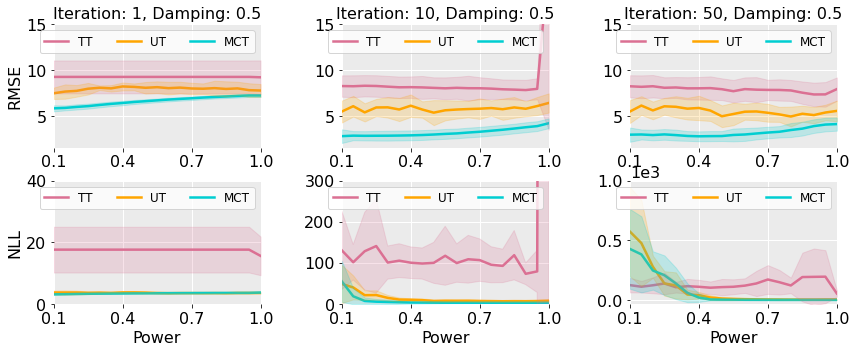

In [8]:
# Plot power sweep for fixed damping rate
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(xticks=np.linspace(1, 19, 4),
                         xtick_labels=np.linspace(0.1, 1.0, 4),
                         vmin_rmse=1.5, vmax_rmse=15,
                         vmin_nll=None, vmax_nll=None,
                         xmin=1, xmax=19)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)
iter_list = [1, 10, 50]
damping = 0.5
damping_list = [damping for _ in iter_list]
control_vars = {'Iter': iter_list, 'Damping': damping_list}
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, colors=colors)
axs[1, 0].set_ylim(0, 40)
axs[1, 1].set_ylim(0, 300)
axs[1, 2].set_ylim(-30, 1000)

plt.show()

In [9]:
# Plots in paper (power sweep)
plot_config = PlotConfig(figsize=(8,4),
                         xticks=np.linspace(1, 19, 4),
                         xtick_labels=np.linspace(0.1, 1.0, 4),
                         vmin_rmse=1.5, vmax_rmse=15,
                         vmin_nll=None, vmax_nll=None,
                         xmin=1, xmax=19,
                         xlabel_fontsize=26, ylabel_fontsize=26,
                         title_fontsize=26, legend_fontsize=22,
                         xtick_labelsize=22, ytick_labelsize=22)

iter_list = [1, 10, 50]
damping = 0.5
damping_list = [damping for _ in iter_list]
control_vars = {'Iter': iter_list, 'Damping': damping_list}

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, xlabel=False)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, title=False)
ax.set_ylim(-3, 40)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, xlabel=False, ylabel=False)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, ylabel=False, title=False, figsize=(8,4.3))
ax.set_ylim(-10, 290)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf", bbox_inches='tight')

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, xlabel=False, ylabel=False)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, ylabel=False, title=False)
ax.set_ylim(-30, 900)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

plt.close('all') # plt.show()

## 2. Plots for the Bearings-only turning target tracking experiment

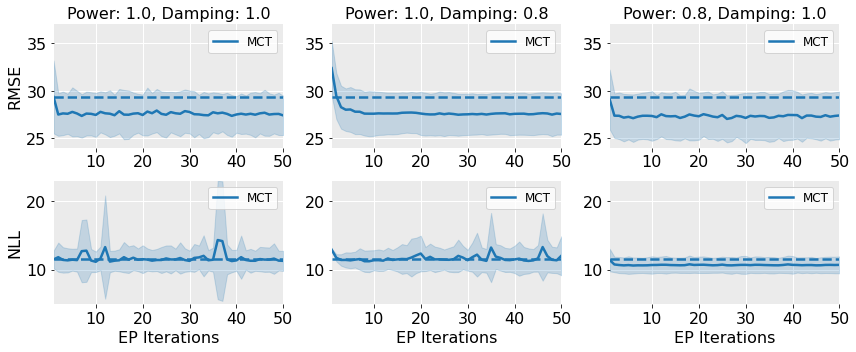

In [11]:
# Plot MCT results only
experiment = 'bott'
exp_table, cursor = select_data(experiment)
Seeds = np.arange(101, 1101, 100)
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=24,
                         vmax_rmse=37,
                         vmin_nll=5,
                         vmax_nll=23,
                         xmin=1,
                         xmax=50)
                         
# plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
#                          vmin_rmse=None,
#                          vmax_rmse=None,
#                          vmin_nll=None,
#                          vmax_nll=None,
#                          xmin=1,
#                          xmax=50)

exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)
power_list = [1.0, 1.0, 0.8]
damping_list = [1.0, 0.8, 1.0]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors = ['C0']
trans_types = ['MCT']
# ['palevioletred', 'orange', 'darkturquoise']
# ['salmon', 'orange', 'grey']
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, iter_display_name='EP Iterations', colors=colors, trans_types=trans_types)
axs = plot_first_iteration_results(axs, exp_config, colors=colors, trans_types=trans_types)
plt.savefig("figs/bearings_only_MCT_results.pdf")

plt.show()